In [6]:

!pip install mlxtend


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
from google.colab import files


In [8]:
# Upload your CSV file (use sample_online_retail.csv)
uploaded = files.upload()

# Load CSV and parse dates
df = pd.read_csv("sample_online_retail.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# View structure
df.head()


Saving sample_online_retail.csv to sample_online_retail (1).csv


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,10001,A100,Tea,2,2023-01-01,1.5,12345,United Kingdom
1,10001,A101,Biscuits,1,2023-01-01,2.0,12345,United Kingdom
2,10002,A100,Tea,5,2023-01-02,1.5,12346,United Kingdom
3,10003,A102,Sugar,3,2023-01-03,1.0,12347,United Kingdom
4,10003,A103,Milk,4,2023-01-03,1.2,12347,United Kingdom


In [9]:
# Remove missing CustomerIDs
df.dropna(subset=['CustomerID'], inplace=True)

# Remove cancelled or invalid orders
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Calculate TotalAmount
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,10001,A100,Tea,2,2023-01-01,1.5,12345,United Kingdom,3.0
1,10001,A101,Biscuits,1,2023-01-01,2.0,12345,United Kingdom,2.0
2,10002,A100,Tea,5,2023-01-02,1.5,12346,United Kingdom,7.5
3,10003,A102,Sugar,3,2023-01-03,1.0,12347,United Kingdom,3.0
4,10003,A103,Milk,4,2023-01-03,1.2,12347,United Kingdom,4.8


In [10]:
# Set reference date as most recent transaction
reference_date = df['InvoiceDate'].max()

# RFM Table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalAmount': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12345,3,2,5.0
1,12346,2,1,7.5
2,12347,1,2,7.8
3,12348,0,1,6.6


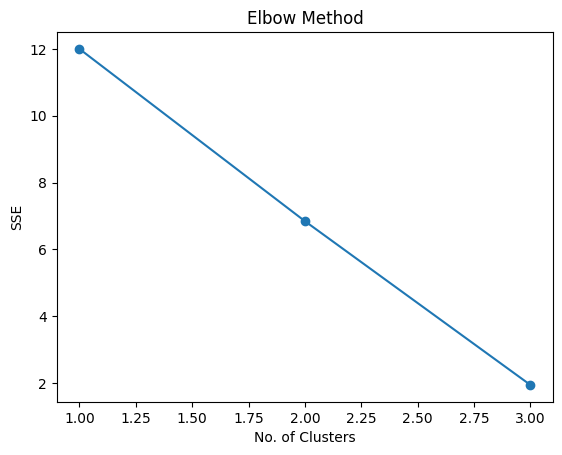

In [15]:
# Reduce range based on number of customers
sse = []
for k in range(1, 4):  # k must be ≤ number of customers
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 4), sse, marker='o')
plt.xlabel('No. of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()


In [16]:
# Apply KMeans with k=3 or 4 based on elbow
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Cluster-wise summary
rfm.groupby('Cluster').mean()


,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
0,12347.0,1.0,1.0,7.05
1,12347.0,1.0,2.0,7.80
2,12345.0,3.0,2.0,5.00


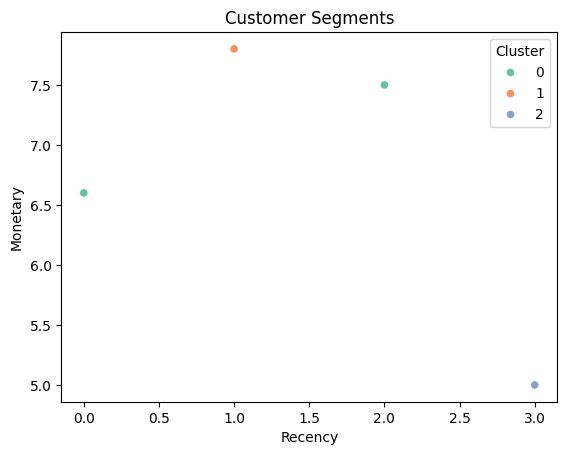

In [17]:
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2')
plt.title("Customer Segments")
plt.show()


In [18]:
# Filter UK transactions
basket_df = df[df['Country'] == 'United Kingdom']

# Pivot to create basket matrix
basket = basket_df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)

# Binarize quantities
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

basket.head()


/tmp/ipython-input-18-2680155003.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


Description,Biscuits,Bread,Milk,Sugar,Tea
InvoiceNo,,,,,
10001,1,0,0,0,1
10002,0,0,0,0,1
10003,0,0,1,1,0
10004,0,1,0,0,0


In [19]:
# Frequent itemsets
frequent_items = apriori(basket, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_items, metric='lift', min_threshold=1.0)

# Top rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10)


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
3,(Milk),(Sugar),0.25,1.0,4.0
2,(Sugar),(Milk),0.25,1.0,4.0
1,(Biscuits),(Tea),0.25,1.0,2.0
0,(Tea),(Biscuits),0.25,0.5,2.0


In [20]:
rfm.to_csv("customer_segments.csv", index=False)
rules.to_csv("market_basket_rules.csv", index=False)
